# Parkinson's dataset

Parkinson's disorder is a nervous system condition that progresses over time, resulting in impairments to motor function and speech. About 1 million Americans have Parkinson's, and 60,000 new cases are reported every year. The symptoms of the disease can severely restrict the quality of life of those affected by it, and frequent visits required for monitoring of the disorder can be both expensive and difficult given the condition of the patients. Using a reliable device to track the progression of the disease would be of great benefit to those affected.

The use of voice recordings to track the progression of Parkinson's shows great potential. 90% of people with Parkinson's exhibit some kind of vocal impairment, and the monitoring of voice signals would be non-invasive for the patient, and would allow for reduced clinical visits and more frequent monitoring. The signals measured from voice recordings can be interpereted by software to yield metrics that can be used to characterize the properties of the sound, allowing for the detection of tremor, roughness, and reduced loudness, all associated with Parkinson's.

In this exercise, data obtained from the UCI Machine Learning repository on voice recordings from 42 patients with Parkinson's will be used to predict the severity of Parkinson's. The severity is traditonally assessed by a physician using the UPDRS scale, which ranges from 0 (no disability at all) to 199 (complete disability). Regression models will be performed on this dataset to predict the UPDRS score using features obtained from the analysis of the recorded sound.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import statsmodels.api as sm

from IPython.display import Image  
from sklearn.tree import export_graphviz

pd.set_option('display.max_rows', 999) 
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 1000)

import time

import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [2]:
#load dataset
df = pd.read_csv("parkinsons_updrs.csv")

In [3]:
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [4]:
df.shape

(5875, 22)

# EDA

### Data Structure 

In [5]:
df.describe()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,0.008962,0.034035,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,0.009371,0.025835,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,0.000980,0.003060,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,0.004730,0.019120,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,0.002490,0.006750,0.027510,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,0.009870,0.039750,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,0.172630,0.268630,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


In [6]:
len(df['subject#'].unique())

42

**Upon analyzing the dataset and reading the metadata, the following is determined:**

**"motor_DPDRS" and "total_UPDRS" represent the UPDRS score, a metric used to describe the severity of Parkinson's disease. Either of these two features could serve as the label for machine learning analysis, and models will be fitted to both to determine which is the better label. A correlation matrix will be computed below to see if one label has more features correlated with it than the other.**

**From the max subject #, we see that the 5875 observations in the dataset do not represent 5875 individuals, but rather 42 individuals measured over time (a longitudinal study). The column "subject #" corresponds to the ID of each patient: this is not an ordinal variable, and would corrupt the model if new patient #'s were added. Based on this consideration, it would be best if this feature were not included in the model.**

**From literature, the total UPDRS score can range from 0 (no disability at all) to 199 (complete disability). The motor UPDRS contributes up to 108 points of the total score. The individuals in this dataset have total UPDRS scores ranging from 7 to 54 with an mean of 29.** 

**From the metadata it is stated that all of the individuals have early stage Parkinson's, which means that classification on this dataset cannot be performed. Instead, regression will be performed to predict the severity of the disease as measured on the UPDRS scale.** 

### Correlation Matrix

In [7]:
#Rearrange df columns so labels come first
firstcols = ['total_UPDRS','motor_UPDRS','sex','age']
df = df[firstcols + [c for c in df if c not in firstcols]]

In [8]:
#Correlation Matrix
corr = df.corr()
corr

,total_UPDRS,motor_UPDRS,sex,age,subject#,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
total_UPDRS,1.000000,0.947231,-0.096559,0.310290,0.253643,0.075263,0.074247,0.066927,0.064015,0.063352,0.064027,0.092141,0.098790,0.079363,0.083467,0.120838,0.079363,0.060952,-0.162117,0.156897,-0.113475,0.156195
motor_UPDRS,0.947231,1.000000,-0.031205,0.273665,0.252919,0.067918,0.084816,0.050903,0.072684,0.076291,0.072698,0.102349,0.110076,0.084261,0.092105,0.136560,0.084260,0.074967,-0.157029,0.128607,-0.116242,0.162433
sex,-0.096559,-0.031205,1.000000,-0.041602,0.286851,-0.009805,0.051422,-0.154645,0.076718,0.087995,0.076703,0.058736,0.056481,0.044937,0.064819,0.023360,0.044938,0.168170,-0.000167,-0.159262,-0.165113,-0.099901
age,0.310290,0.273665,-0.041602,1.000000,-0.030864,0.019884,0.023071,0.035691,0.010255,0.013199,0.010258,0.101554,0.111130,0.098912,0.089983,0.135238,0.098913,0.007093,-0.104842,0.090208,-0.092870,0.120790
subject#,0.253643,0.252919,0.286851,-0.030864,1.000000,-0.000882,0.135448,0.075156,0.120339,0.136474,0.120350,0.146202,0.142864,0.112950,0.138264,0.173333,0.112949,0.168743,-0.206929,0.147300,0.097464,0.157559
test_time,0.075263,0.067918,-0.009805,0.019884,-0.000882,1.000000,-0.022837,-0.011365,-0.028888,-0.023290,-0.028876,-0.033870,-0.030962,-0.029020,-0.036504,-0.039110,-0.029017,-0.026357,0.036545,-0.038887,0.019261,-0.000563
Jitter(%),0.074247,0.084816,0.051422,0.023071,0.135448,-0.022837,1.000000,0.865577,0.984181,0.968214,0.984184,0.709791,0.716704,0.664149,0.694002,0.645965,0.664147,0.825294,-0.675188,0.427128,0.226550,0.721849
Jitter(Abs),0.066927,0.050903,-0.154645,0.035691,0.075156,-0.011365,0.865577,1.000000,0.844626,0.790538,0.844630,0.649046,0.655871,0.623830,0.621401,0.589998,0.623827,0.699960,-0.706418,0.547100,0.352264,0.787853
Jitter:RAP,0.064015,0.072684,0.076718,0.010255,0.120339,-0.028888,0.984181,0.844626,1.000000,0.947196,1.000000,0.681729,0.685551,0.650226,0.659831,0.603082,0.650225,0.792373,-0.641473,0.382891,0.214881,0.670652
Jitter:PPQ5,0.063352,0.076291,0.087995,0.013199,0.136474,-0.023290,0.968214,0.790538,0.947196,1.000000,0.947203,0.732747,0.734591,0.676711,0.734021,0.668413,0.676710,0.864864,-0.662409,0.381503,0.175359,0.663491


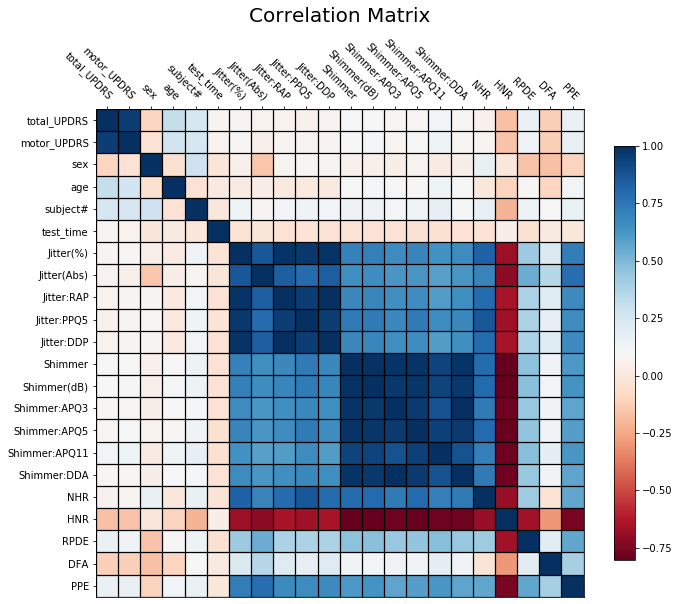

In [261]:
#Correlation Heatmap
#Define feature names and convert corr to an array
corr_features = list(corr.index)
heatmap_values = corr.values

#Create Heatmap and map data to it
fig, htmp = plt.subplots(tight_layout=True, figsize=(10,10))
im = htmp.imshow(heatmap_values, cmap=plt.cm.RdBu)

#Determine range of ticks to show, and define labels
htmp.set_xticks(np.arange(len(corr_features)))
htmp.set_yticks(np.arange(len(corr_features)))
htmp.set_xticklabels(corr_features)
htmp.set_yticklabels(corr_features)

#Put X axis on top
htmp.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

#Define Colorbar
plt.colorbar(im, ax=htmp, shrink = 0.6)

#Minor ticks, which center labels above correlated features and creates a border between values
htmp.set_xticks(np.arange(len(corr_features)+1)-.5, minor=True)
htmp.set_yticks(np.arange(len(corr_features)+1)-.5, minor=True)
htmp.grid(which="minor", color="#000000", linestyle='-', linewidth=1.25)
htmp.tick_params(which="minor", bottom=False, left=False)

#Rotate labels
plt.setp(htmp.get_xticklabels(), rotation= -45, ha="right", rotation_mode="anchor")
        
htmp.set_title("Correlation Matrix", fontsize=20, pad=15)
plt.savefig("correlation_matrix.png")

plt.show()

**The correlation matrix reveals a high degree of correlation between features, which will cause problems with models such as linear regression. Based on this, dimensionality reduction should be performed before linear regression to avoid overfitting in the model.**

**The features HNR (Harmonics to Noise Ratio), and DFA (Detrended Fluctuation Analysis), are most highly correlated features for both labels. DFA is also correlated with other features to a much lesser degree than the other features, which highlights its usefulness in a model.**

### Scatterplots of Features vs Total UPDRS Score

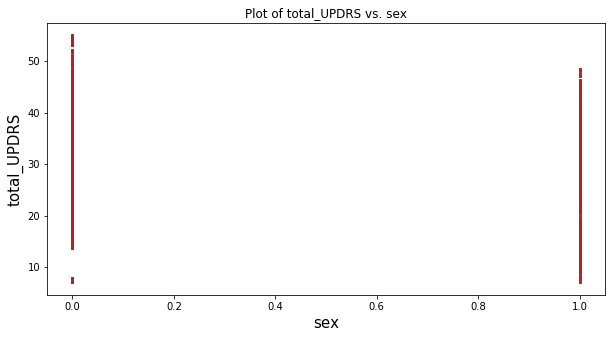

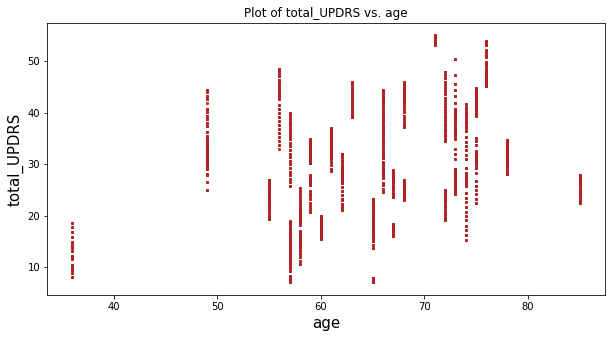

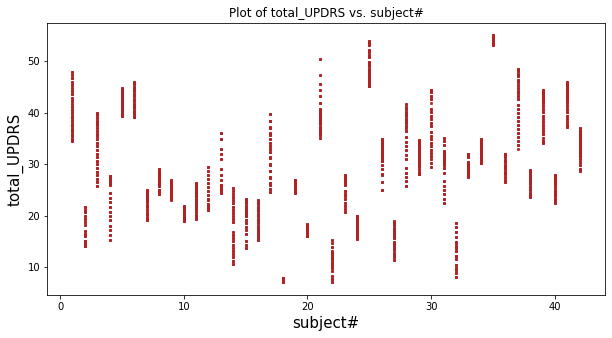

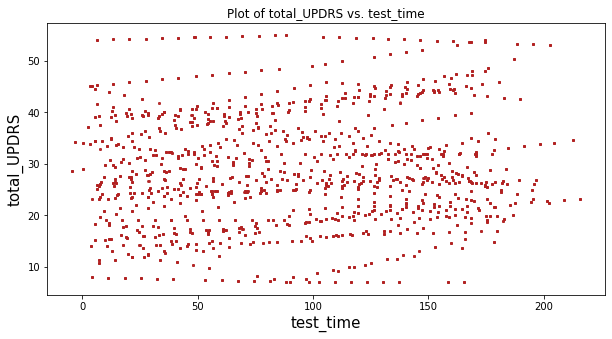

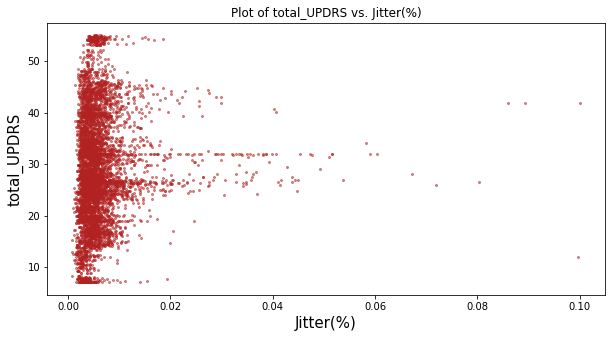

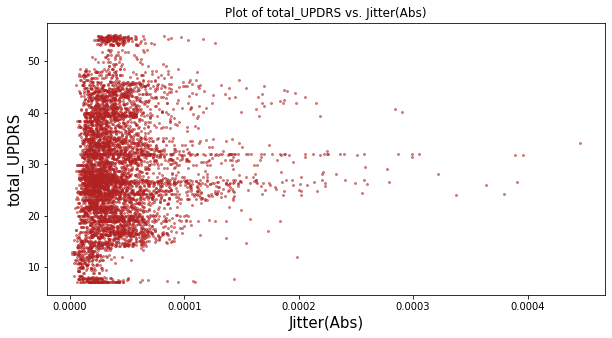

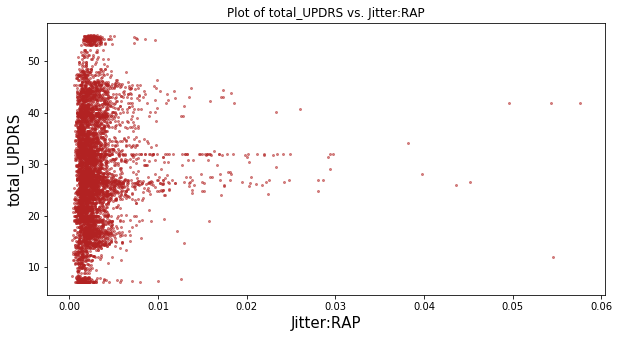

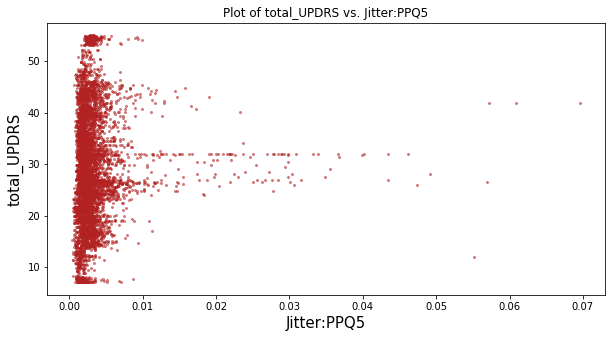

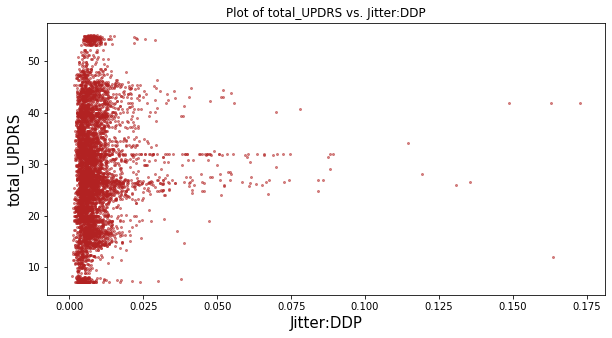

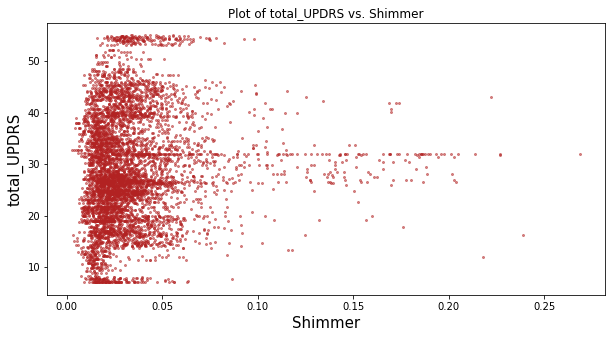

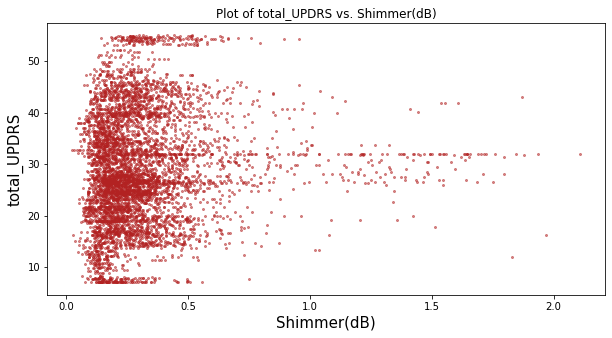

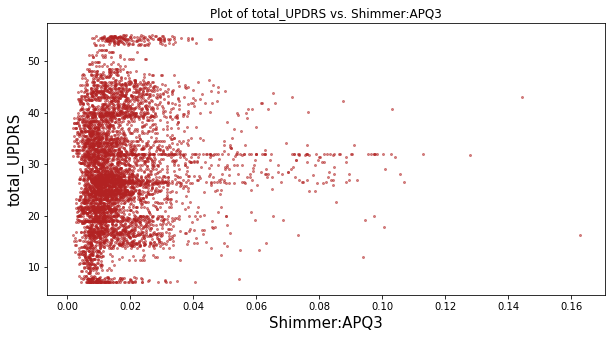

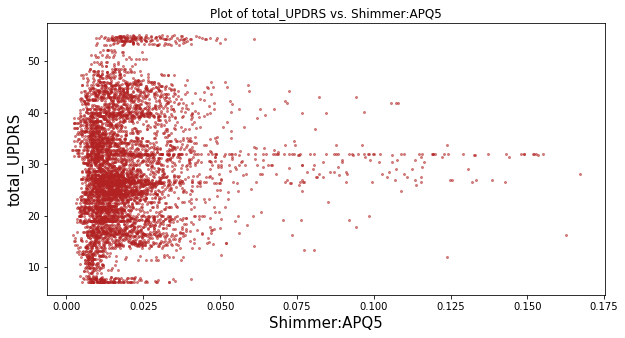

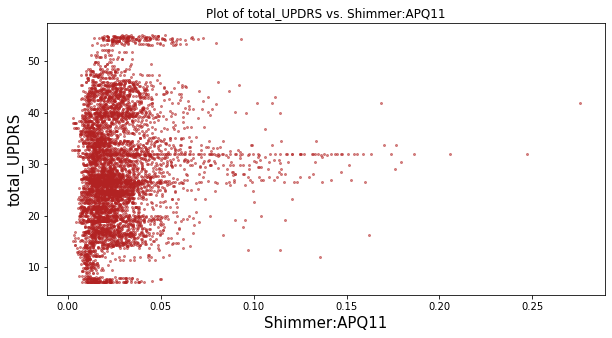

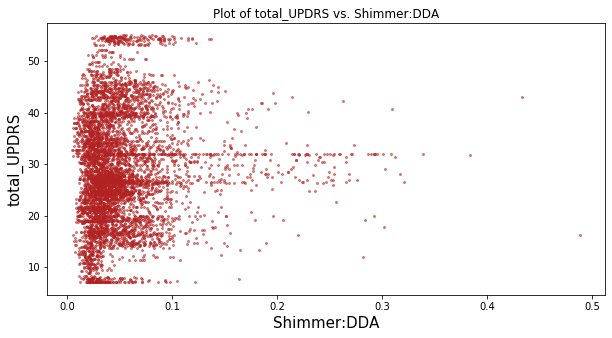

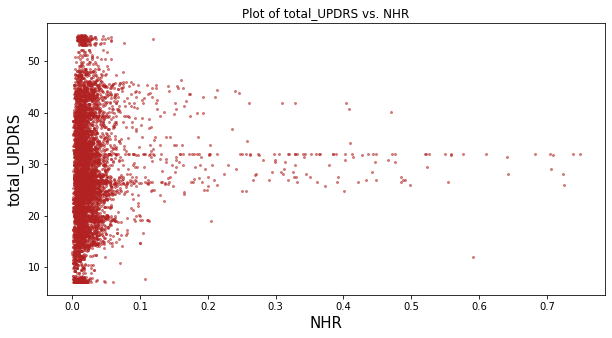

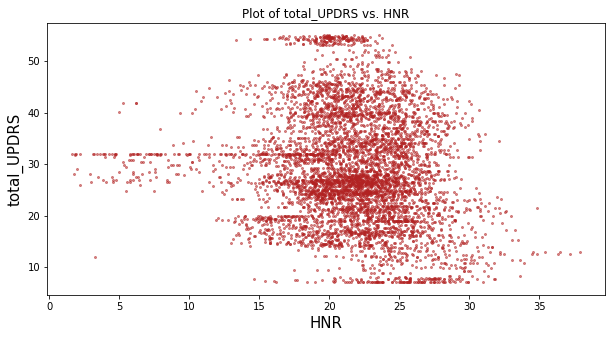

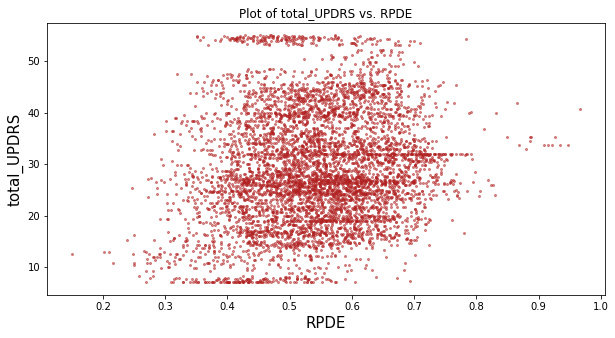

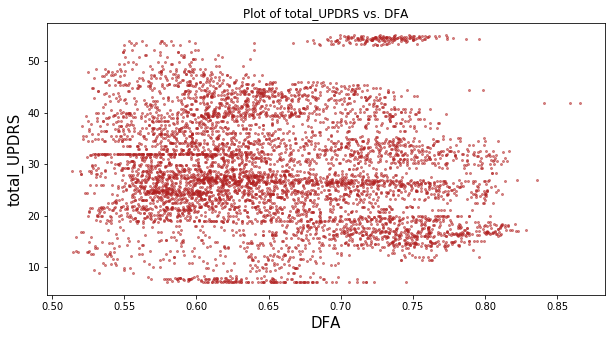

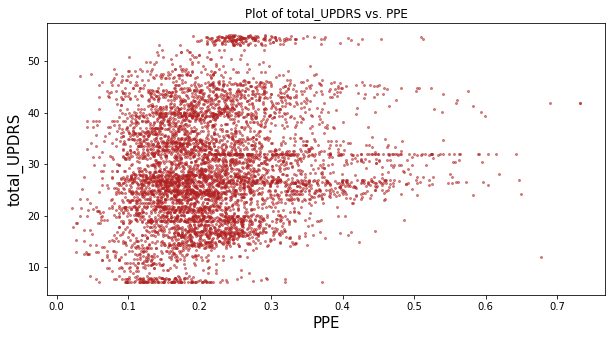

In [10]:
#Create scatterplot
for f in df.drop(['total_UPDRS','motor_UPDRS'], axis=1, inplace=False).columns.values:
    color1 = "firebrick"
    fig, ax = plt.subplots(figsize=(10,5))
    
    #Set elements of each plot
    ax.plot(df[f],df['total_UPDRS'],linestyle="none",marker='o',markersize=2,alpha=0.5,color=color1)
    ax.set_title("Plot of total_UPDRS vs. {}".format(f))
    ax.set_xlabel(f, fontsize = 15)
    ax.set_ylabel("total_UPDRS", fontsize = 15)
    
    plt.show()

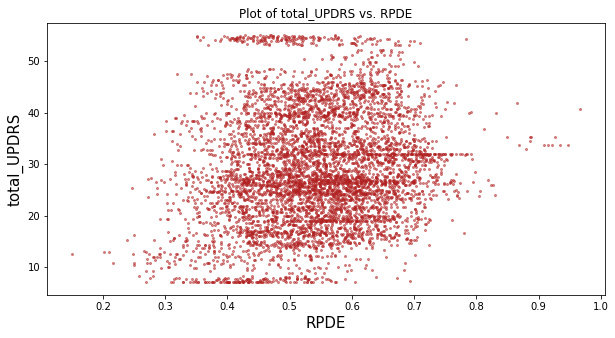

In [263]:
color1 = "firebrick"
fig, ax = plt.subplots(figsize=(10,5))
    
#Set elements of each plot
ax.plot(df['RPDE'],df['total_UPDRS'],linestyle="none",marker='o',markersize=2,alpha=0.5,color=color1)
ax.set_title("Plot of total_UPDRS vs. RPDE")
ax.set_xlabel("RPDE", fontsize = 15)
ax.set_ylabel("total_UPDRS", fontsize = 15)

plt.savefig("UPDRS_vs_RPDE")
plt.show()

**The scatterplots created show no strong correlations between a single feature and the label. RPDE appears to show the strongest relationship between points, though it appears be be a weak correlation.**

# Data Cleaning and Preprocessing

### Considerations for Preprocessing

**Subject ID will be dropped to avoid confounding the models. Test_time will also be dropped as it could also exhibit confounding effects.**

**Sex is a categoical variable, and all other variables are numeric.**

**There are no missing values in the data, so it is not necessary to impute or drop rows.**

**Sex will be converted to dummy variables with OneHotEncoder. Numeric values and features will be scaled using StandardScaler.**

In [53]:
#Transform Features for Total_UPDRS as Label
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

#Select label and features
y1 = df['total_UPDRS']
X1 = df.drop((['motor_UPDRS', 'total_UPDRS','subject#','test_time']),axis=1)

#Specify categorical and numeric features
categorical_features=['sex']
numeric_features=list(set(X1.columns)-set(categorical_features))

#Convert dfs into arrays
X1=X1.values
y1=y1.values

#Perform Dummy Variable Encoding with OneHotEncoder
ct = ColumnTransformer([('onehotencoder', OneHotEncoder(), [0])], remainder='passthrough')
X1 = np.array(ct.fit_transform(X1), dtype=np.float)

#Train-test split (to be used with all models except the decision tree regressor)
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

#Standard Scaler for features
scalerX = StandardScaler()
X1sc_train = scalerX.fit_transform(X1_train)
X1sc_test = scalerX.transform(X1_test)

#Standard Scaler for Label
scalerY = StandardScaler()
y1sc_train = scalerY.fit_transform(y1_train.reshape(-1,1))
y1sc_test = scalerY.transform(y1_test.reshape(-1,1))

#Convert y back to a 1-D array from a column vector 
y1sc_train = y1sc_train.ravel()
y1sc_test = y1sc_test.ravel()

In [33]:
#New categorical Features
new_categorical_features = ['Is_male','Is_female']

In [34]:
initial_feature_names = df.drop((['motor_UPDRS','sex','total_UPDRS','subject#','test_time']),axis=1).columns.values

In [35]:
all_features = new_categorical_features.copy()

In [36]:
for i in range(len(initial_feature_names)):
    all_features.append(initial_feature_names[i])

In [37]:
#Visualize Features after transformation
pd.DataFrame(X1sc_train, columns = all_features).describe()

,Is_male,Is_female,age,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03,4.700000e+03
mean,-4.555694e-16,1.136207e-16,-2.436703e-16,-2.744194e-15,3.096793e-15,2.308481e-15,2.643533e-15,-2.233841e-15,-1.518478e-15,-5.091554e-16,-1.676390e-15,-9.398156e-16,-3.787396e-16,2.679417e-15,-1.139287e-15,-2.557496e-14,-3.411946e-15,1.795609e-14,-1.669415e-15
std,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00
min,-1.472838e+00,-6.789613e-01,-3.299556e+00,-9.768654e-01,-1.183456e+00,-8.888176e-01,-7.977903e-01,-8.899596e-01,-1.207151e+00,-1.245066e+00,-1.180292e+00,-1.098006e+00,-1.266000e+00,-1.180031e+00,-5.394634e-01,-4.662062e+00,-3.864543e+00,-1.959346e+00,-2.157622e+00
25%,-1.472838e+00,-6.789613e-01,-7.753695e-01,-4.701868e-01,-6.153394e-01,-4.654062e-01,-4.028791e-01,-4.659855e-01,-5.782262e-01,-5.917999e-01,-5.954055e-01,-5.625865e-01,-5.962004e-01,-5.955271e-01,-3.571829e-01,-5.375697e-01,-7.006196e-01,-8.009331e-01,-7.000916e-01
50%,6.789613e-01,-6.789613e-01,2.778070e-02,-2.214537e-01,-2.628859e-01,-2.423366e-01,-2.138859e-01,-2.423539e-01,-2.544244e-01,-2.542058e-01,-2.622469e-01,-2.573248e-01,-2.384912e-01,-2.623693e-01,-2.280110e-01,5.383970e-02,2.012803e-02,-1.360970e-01,-1.471776e-01
75%,6.789613e-01,1.472838e+00,8.309309e-01,1.249303e-01,2.703966e-01,1.112078e-01,5.973123e-02,1.111917e-01,2.267307e-01,2.412244e-01,2.646663e-01,2.213121e-01,2.706885e-01,2.644155e-01,-7.025004e-03,6.440845e-01,7.179135e-01,8.176486e-01,4.968493e-01
max,6.789613e-01,1.472838e+00,2.322496e+00,1.729305e+01,1.137233e+01,1.735407e+01,1.624263e+01,1.735299e+01,9.181497e+00,7.878742e+00,1.110558e+01,8.900525e+00,1.116780e+01,1.110581e+01,1.222118e+01,3.773733e+00,4.193790e+00,2.890848e+00,5.573065e+00


**From this, it is observed that most features range between 0 and 1; this will optimize model performance.**

# Models and Results

## 1) PCA-SVR vs. SVR

**Due to the high prevalence of correlated features, dimensionality reduction should be performed to avoid overfitting and low data density. In this section, an ensemble method of PCA followed by SVR will be applied, and the results will be compared to SVR without first using PCA.**

In [38]:
#Total number of features before PCA
print("Before PCA, there are {} features.".format(X1_train.shape[1]))

Before PCA, there are 19 features.


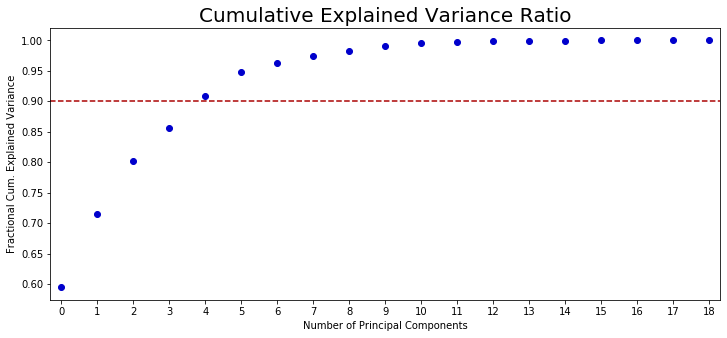

In [264]:
#Part 1: determine the optimal number of principal components to use
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X1sc_train)

fig, ax = plt.subplots(figsize=(12,5))

ax.plot(np.cumsum(pca.explained_variance_ratio_), marker='o',color='#0000CC',linestyle='none')
ax.axhline(y=0.9,c='#AA0000',ls='--')
ax.set_title("Cumulative Explained Variance Ratio", fontsize=20)
ax.set_xlabel("Number of Principal Components")
ax.set_ylabel("Fractional Cum. Explained Variance")

ax.set_xticks(range(0,19))
ax.set_xlim(left=-0.3,right=18.3)

plt.savefig("cum_exp_var.png")
plt.show()

In [40]:
print("The first 4 Principal components explain {0:.2%} of the variance.".format(np.cumsum(pca.explained_variance_ratio_)[5]))

The first 4 Principal components explain 94.75% of the variance.


**Based on the information above, the ideal number of principal components to choose is 4, as 4 components explain 94.75% of the variance.**

In [41]:
#Visualizing coefficients Features constituting principal components in a dataframe
pd.DataFrame(pca.components_[1:5], columns=all_features, index=['PC1','PC2','PC3','PC4'])

,Is_male,Is_female,age,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
PC1,-0.619397,0.619397,-0.049423,-0.013117,-0.190029,0.007325,0.036874,0.007314,0.069173,0.064735,0.065106,0.079645,0.034557,0.065108,0.133454,0.058319,-0.202532,-0.269894,-0.180105
PC2,-0.137657,0.137657,-0.238181,0.310734,0.243457,0.331764,0.260136,0.331761,-0.236680,-0.230097,-0.266188,-0.246309,-0.272057,-0.266188,0.069949,0.090410,-0.063595,0.197884,0.141822
PC3,0.232568,-0.232568,0.330915,0.153459,0.011270,0.165700,0.181780,0.165695,-0.014330,-0.008012,-0.026823,-0.014632,-0.085143,-0.026822,0.213082,0.229649,-0.238588,-0.688033,-0.181824
PC4,0.182396,-0.182396,-0.842540,-0.010847,-0.064048,0.006242,0.038557,0.006243,0.094026,0.076974,0.115234,0.112394,0.026331,0.115235,0.092512,0.140537,-0.268656,-0.056514,-0.243880


In [265]:
pca.components_[2]

array([-0.13765724,  0.13765724, -0.23818053,  0.31073415,  0.24345695,
        0.33176377,  0.26013645,  0.33176074, -0.23668028, -0.23009708,
       -0.26618803, -0.24630939, -0.27205702, -0.26618836,  0.06994948,
        0.09041014, -0.06359529,  0.19788386,  0.14182196])

In [275]:
np.where((np.abs(pca.components_[2]))==np.max(np.abs(pca.components_[2])))[0][0]

5

In [276]:
all_features[5]

'Jitter:RAP'

### Feature Importance from PCA

The features with the highest coefficients in the first principal component are sex (is_male and is_female). In the second principal component, the feature with the highest coefficient is Jitter:RAP. The next highest is jitter:DDP, followed by Shimmer(Db) and NHR.

In [42]:
#Condensing feature datasets to 4 principal components
pca = PCA(n_components = 4)
X1sc_pca_train = pca.fit_transform(X1sc_train)
X1sc_pca_test = pca.fit_transform(X1sc_test)

In [48]:
#Perform GridSearchCV to find the optimal hyperparameters for SVR
from sklearn.model_selection import GridSearchCV
import time
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error

SVR_hptest1 = {'C':[0.1,0.5,1,5,10,50,100,500,1000],
              'epsilon':[0.001,0.005,0.01,0.05,0.1,0.5]}

#Print number of parameters entered
param_num = []
for key,value in SVR_hptest1.items():
    param_num.append(len(value))
result = 1
for x in param_num: 
    result = result * x  
print("{} hyperparameters will be tested.".format(result))  

mod=SVR()
lots_of_SVRs = GridSearchCV(mod, SVR_hptest1, cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)

54 hyperparameters will be tested.


In [49]:
tic=time.time()
lots_of_SVRs.fit(X1sc_pca_train,y1sc_train)
toc=time.time()
print("Time Elapsed: {} seconds".format(toc-tic))

C:\ProgramData\Anaconda3\envs\timebomb\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Time Elapsed: 310.6969804763794 seconds


In [54]:
print("Parameters of best estimator: {}".format(lots_of_SVRs.best_params_))
print("MSE of best estimator: {}".format((-1)*lots_of_SVRs.best_score_))

Parameters of best estimator: {'C': 500, 'epsilon': 0.5}
MSE of best estimator: 0.7158363084940501


In [148]:
SVR_params_2 = {'C':[250,300,400,500,600,700,800],
              'epsilon':[0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7]}

#Print number of parameters entered
param_num = []
for key,value in SVR_params_2.items():
    param_num.append(len(value))
result = 1
for x in param_num: 
    result = result * x  
print("{} hyperparameters will be tested.".format(result))  

mod=SVR()
lots_of_SVRs2 = GridSearchCV(mod, SVR_params_2, cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)

63 hyperparameters will be tested.


In [149]:
tic=time.time()
lots_of_SVRs2.fit(X1sc_pca_train,y1sc_train)
toc=time.time()
print("Time Elapsed: {} seconds".format(toc-tic))

Time Elapsed: 403.2501039505005 seconds


Gridsearch will  be performed again with linear kernel.

In [150]:
print("Parameters of best SVR: {}".format(lots_of_SVRs2.best_params_))
print("Mean Squared Error of best SVR: {0:.9f}".format(-1*lots_of_SVRs2.best_score_))

Parameters of best SVR: {'C': 250, 'epsilon': 0.5}
Mean Squared Error of best SVR: 0.714029020


The best C was on the lowest end of the range entered in the hyperparameter space, so fitting will be performed again with values between 100, the best value from the first trial, and 250. The epsilon value will be tested again in a much smaller range around 0.5.

In [152]:
SVR_params_3 = {'C':[100,125,150,175,200,225,250],
              'epsilon':[0.46,0.48,0.5,0.52,0.54]}

#Print number of parameters entered
param_num = []
for key,value in SVR_params_3.items():
    param_num.append(len(value))
result = 1
for x in param_num: 
    result = result * x  
print("{} hyperparameters will be tested.".format(result))  

mod=SVR()
lots_of_SVRs3 = GridSearchCV(mod, SVR_params_3, cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)

35 hyperparameters will be tested.


In [154]:
tic=time.time()
lots_of_SVRs3.fit(X1sc_pca_train,y1sc_train)
toc=time.time()
print("Fitting complete. Time elapsed: {0:.3f} seconds".format(toc-tic))

Fitting complete. Time elapsed: 97.162 seconds


In [155]:
print("Parameters of best SVR: {}".format(lots_of_SVRs3.best_params_))
print("Mean Squared Error of best SVR: {0:.9f}".format(-1*lots_of_SVRs3.best_score_))

Parameters of best SVR: {'C': 225, 'epsilon': 0.48}
Mean Squared Error of best SVR: 0.713733602


In [156]:
from sklearn.model_selection import cross_validate

In [203]:
#Create a 2D array containing the 5-fold CV results of the best estimator
#Will iterate over train and test set for MSE, R^2, and MAE
scorers = ["neg_mean_squared_error","r2","neg_median_absolute_error"]
X = [X1sc_pca_train, X1sc_pca_test]
y= [y1sc_train, y1sc_test]
pca_svr_points = []
t0=time.time()
for i in range(2):
    for j in range(3):
        points = cross_validate(estimator = lots_of_SVRs3.best_estimator_,
                                  scoring=scorers[j], X = X[i], y = y[i], cv = 5)['test_score']
        pca_svr_points.append(points)
pca_svr_points = np.abs(np.array(pca_svr_points))
t1=time.time()
print("Cross validation complete. Total time elapsed: {0:.3f} seconds.".format(t1-t0))

Cross validation complete. Total time elapsed: 27.893 seconds.


In [216]:
#Create Dataframe for standard deviation and mean for all 3 scoring metrics
pca_svr_std=[]
t0=time.time()
for i in range(6):
    std = np.std(pca_svr_points[i])
    pca_svr_std.append(std)
pca_svr_std_df = pd.DataFrame(np.array(pca_svr_std).reshape((2,3)), 
                              columns=['MSE','R^2','MAE'], index=['Train','Test'])

pca_svr_mean=[]
for i in range(6):
    mean = np.mean(pca_svr_points[i])
    pca_svr_mean.append(mean)    
pca_svr_mean_df = pd.DataFrame(np.array(pca_svr_mean).reshape((2,3)), 
                              columns=['MSE','R^2','MAE'], index=['Train','Test'])

In [217]:
pca_svr_std_df

,MSE,R^2,MAE
Train,0.032976,0.023938,0.019317
Test,0.070487,0.052326,0.015536


In [225]:
pca_svr_mean_df

,MSE,R^2,MAE
Train,0.713734,0.286405,0.517133
Test,0.680129,0.290475,0.510269


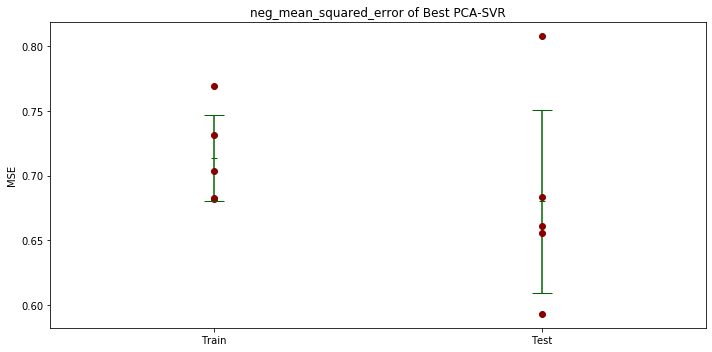

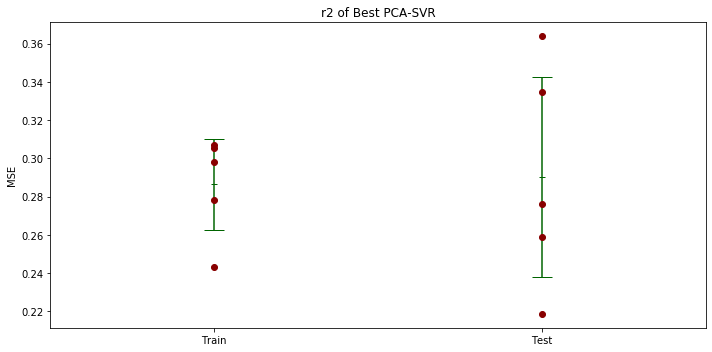

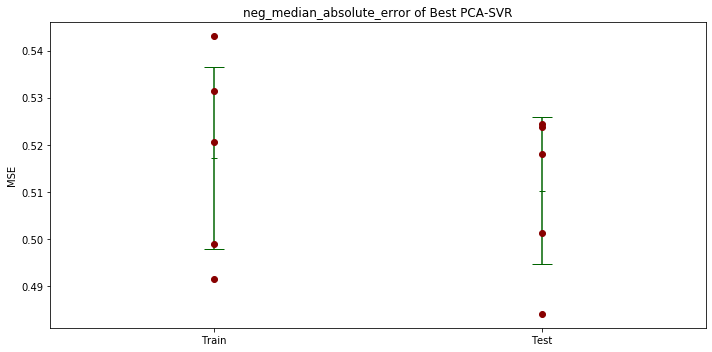

In [277]:
mean_arr = np.array(pca_svr_mean).reshape((2,3)) 
std_arr = np.array(pca_svr_std).reshape((2,3))
pca_svr_points_arr = pca_svr_points.reshape((2,3,5))
for i in range(3):
    fig, ax = plt.subplots(figsize=(10,5), tight_layout=True)
    ax.plot([1,1,1,1,1],pca_svr_points_arr[0][i], linestyle='none',marker="o", color="#880000",label='train')
    ax.plot([2,2,2,2,2],pca_svr_points_arr[1][i], linestyle='none',marker="o", color="#880000",label='test')
    ax.errorbar([1],mean_arr[0][i],std_arr[0][i],
               linestyle='none', marker='_', color='darkgreen', capsize=10, label='train')
    ax.errorbar([2],mean_arr[1][i],std_arr[1][i],
               linestyle='none', marker='_', color='darkgreen', capsize=10, label='train')
    ax.set_title("{} of Best PCA-SVR".format(scorers[i]), fontsize=12)
    ax.set_xticklabels(['Train','Test'])
    ax.set_xticks([1,2])
    ax.set_ylabel("MSE")
    ax.set_xlim(left=0.5,right=2.5)
    filename=str(scorers[i])+"_pca_svr.png"
    plt.savefig(filename)

## 2) Decision Tree Regression

Decision tree regression will split nodes containing each operation into smaller samples and will repeat a mean value instead of purity. This method is not confounded by colinearity of features, so dimensionality reduction is not required for this model.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
#Construct first tree to determine max depth without restrictions
t0=time.time()
reg=DecisionTreeRegressor(random_state=24)
reg.fit(X1_train,y1_train)
t1=time.time()
print("Time to fit one tree: {0:.3f} seconds.".format(t1-t0))

from sklearn import tree
dot_data = tree.export_graphviz(reg, out_file=None,
                                feature_names=list(all_features),
                                filled=True, 
                                rounded=True,special_characters=True)
import graphviz
graph = graphviz.Source(dot_data).view(filename='default_tree.gv')
from graphviz import render
render('dot', 'png', 'default_tree.gv')

The Decision Tree Output is below. The depth of the tree with default settings is 25.

![standard tree](default_tree.gv.png)

In [114]:
DTR_params_1={
'max_depth' : [7,10,11,12,13,15,20,None],
'min_samples_split': [100,150,175,200,225,250],
'min_samples_leaf': [8,10,11,12,13,14,16],
'max_features': [4,6,8,10,12,15,None]
}

#Print number of parameters entered
param_num = []
for key,value in DTR_params_1.items():
    param_num.append(len(value))
result = 1
for x in param_num: 
    result = result * x  
print("{} hyperparameters will be tested.".format(result)) 

mod=DecisionTreeRegressor(random_state=24)
lots_of_Trees = GridSearchCV(mod, DTR_params_1, cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)

2352 hyperparameters will be tested.


In [115]:
t0=time.time()
lots_of_Trees.fit(X1_train,y1_train)
t1=time.time()
print("Fitting Complete. Time elapsed: {0:.3f} seconds.".format(t1-t0))

Fitting Complete. Time elapsed: 66.134 seconds.


In [116]:
print("Parameters of best tree: {}".format(lots_of_Trees.best_params_))
print("Mean Squared Error of best tree: {0:.9f}".format(-1*lots_of_Trees.best_score_))

Parameters of best tree: {'max_depth': 13, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 100}
Mean Squared Error of best tree: 18.967521909


The best tree from the first iteration of GridSearchCV has values for min_samples_leaf and min_samples_split that are equal to the lowest values entered in the hyperparameter space. Based on this, another instance of GridSearchCV will be performed with a lower range of those two hyperparameters, with a lower step between each possible hyperparameter. Max_depth will be adjusted only a small amount, within 1 unit of the best value of 13. Max_features will not be adjusted.

In [122]:
DTR_params_2={
'max_depth' : [12,13,14],
'min_samples_split': [20,30,40,50,60,70,80,90,100],
'min_samples_leaf': [2,4,6,8]
}

#Print number of parameters entered
param_num = []
for key,value in DTR_params_2.items():
    param_num.append(len(value))
result = 1
for x in param_num: 
    result = result * x  
print("{} hyperparameters will be tested.".format(result)) 

mod=DecisionTreeRegressor(max_features=None, random_state=24)
lots_of_Trees_2 = GridSearchCV(mod, DTR_params_2, cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)

108 hyperparameters will be tested.


In [123]:
t0=time.time()
lots_of_Trees_2.fit(X1_train,y1_train)
t1=time.time()
print("Fitting Complete. Time elapsed: {0:.3f} seconds.".format(t1-t0))

Fitting Complete. Time elapsed: 8.222 seconds.


In [124]:
print("Parameters of best tree: {}".format(lots_of_Trees_2.best_params_))
print("Mean Squared Error of best tree: {0:.9f}".format(-1*lots_of_Trees_2.best_score_))

Parameters of best tree: {'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 30}
Mean Squared Error of best tree: 15.363433652


In [127]:
#Obtain train and test scores for best estimator to check for overfitting
best = lots_of_Trees_2.best_estimator_

yp = best.predict(X1_train)
DTR_mse_train = mean_squared_error(y1_train,yp)
DTR_R2_train = r2_score(y1_train, yp)
DTR_mae_train = median_absolute_error(y1_train, yp)

yp=best.predict(X1_test)
DTR_mse_test = mean_squared_error(y1_test,yp)
DTR_R2_test = r2_score(y1_test, yp)
DTR_mae_test = median_absolute_error(y1_test, yp)

In [144]:
#Report Train and test scores from best estimator
DTR_train=np.array([DTR_mse_train,DTR_R2_train, DTR_mae_train])
DTR_test=np.array([DTR_mse_test, DTR_R2_test,DTR_mae_test])
pd.DataFrame(np.array([DTR_train,DTR_test]), columns=['MSE','R^2','MAE'], index=['Train','Test'])

,MSE,R^2,MAE
Train,6.183787,0.946403,1.165303
Test,15.341181,0.861558,1.706436


In [247]:
#Determine best ccp_alpha for random forest regressor with the optimal number of trees
dt=lots_of_Trees_2.best_estimator_
reg=lots_of_Trees_2.best_estimator_
path = dt.cost_complexity_pruning_path(X1_train,y1_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

count=1 
regs = []
t0=time.time()
for ccp_alpha in ccp_alphas:
    reg = RFR(n_estimators=500, max_features=None, oob_score=True, random_state=42, ccp_alpha=ccp_alpha, n_jobs=-1)
    reg.fit(X1_train, y1_train)
    regs.append(reg)
    t1=time.time()
    if count%2 == 0:
        print("Finished fitting for {0} ccp_alphas out of {1}. Time elapsed: {2:.3f} seconds.".format(count, len(ccp_alphas),t1-t0))
    count +=1
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      regs[-1].tree_.node_count, ccp_alphas[-1]))

Finished fitting for 2 ccp_alphas out of 245. Time elapsed: 34.537 seconds.
Finished fitting for 4 ccp_alphas out of 245. Time elapsed: 78.622 seconds.
Finished fitting for 6 ccp_alphas out of 245. Time elapsed: 110.776 seconds.
Finished fitting for 8 ccp_alphas out of 245. Time elapsed: 139.004 seconds.
Finished fitting for 10 ccp_alphas out of 245. Time elapsed: 167.946 seconds.
Finished fitting for 12 ccp_alphas out of 245. Time elapsed: 197.893 seconds.
Finished fitting for 14 ccp_alphas out of 245. Time elapsed: 229.768 seconds.
Finished fitting for 16 ccp_alphas out of 245. Time elapsed: 254.751 seconds.
Finished fitting for 18 ccp_alphas out of 245. Time elapsed: 279.959 seconds.
Finished fitting for 20 ccp_alphas out of 245. Time elapsed: 304.804 seconds.
Finished fitting for 22 ccp_alphas out of 245. Time elapsed: 329.519 seconds.
Finished fitting for 24 ccp_alphas out of 245. Time elapsed: 352.616 seconds.
Finished fitting for 26 ccp_alphas out of 245. Time elapsed: 375.114 s

Finished fitting for 210 ccp_alphas out of 245. Time elapsed: 10446.882 seconds.
Finished fitting for 212 ccp_alphas out of 245. Time elapsed: 10473.770 seconds.
Finished fitting for 214 ccp_alphas out of 245. Time elapsed: 10501.374 seconds.
Finished fitting for 216 ccp_alphas out of 245. Time elapsed: 10527.149 seconds.
Finished fitting for 218 ccp_alphas out of 245. Time elapsed: 10550.089 seconds.
Finished fitting for 220 ccp_alphas out of 245. Time elapsed: 10573.562 seconds.
Finished fitting for 222 ccp_alphas out of 245. Time elapsed: 10597.864 seconds.
Finished fitting for 224 ccp_alphas out of 245. Time elapsed: 10623.245 seconds.
Finished fitting for 226 ccp_alphas out of 245. Time elapsed: 10646.548 seconds.
Finished fitting for 228 ccp_alphas out of 245. Time elapsed: 10670.242 seconds.
Finished fitting for 230 ccp_alphas out of 245. Time elapsed: 10694.087 seconds.
Finished fitting for 232 ccp_alphas out of 245. Time elapsed: 10719.420 seconds.
Finished fitting for 234 ccp

AttributeError: 'RandomForestRegressor' object has no attribute 'tree_'

In [254]:
#Calculate scores for train set
t0=time.time()
dtr_mse_train_scores=[]
dtr_r2_train_scores=[]
dtr_mae_train_scores=[]
for reg in regs:
    yp=reg.predict(X1_train)
    dtr_mse_train_scores.append(mean_squared_error(y1_train,yp))
    dtr_r2_train_scores.append(r2_score(y1_train,yp))
    dtr_mae_train_scores.append(median_absolute_error(y1_train,yp))
    
#Calculate scores for test set
dtr_mse_test_scores=[]
dtr_r2_test_scores=[]
dtr_mae_test_scores=[]
for reg in regs:
    yp=reg.predict(X1_test)
    dtr_mse_test_scores.append(mean_squared_error(y1_test,yp))
    dtr_r2_test_scores.append(r2_score(y1_test,yp))
    dtr_mae_test_scores.append(median_absolute_error(y1_test,yp))
t1=time.time()
print("Complete. Time elapsed: {} seconds.".format(t1-t0))

Complete. Time elapsed: 83.84398818016052 seconds.


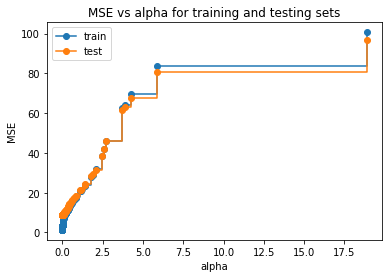

In [282]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE vs alpha for training and testing sets")
ax.plot(ccp_alphas, dtr_mse_train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, dtr_mse_test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

plt.savefig("dtr_mse.png")
plt.show()

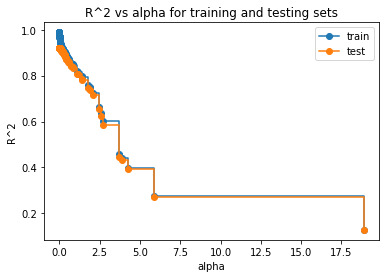

In [283]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("R^2")
ax.set_title("R^2 vs alpha for training and testing sets")
ax.plot(ccp_alphas, dtr_r2_train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, dtr_r2_test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

plt.savefig("dtr_r2.png")
plt.show()

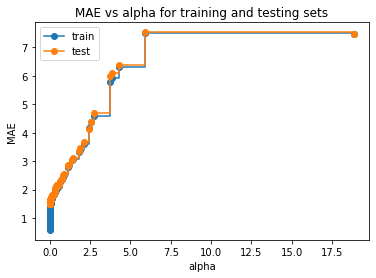

In [281]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("MAE")
ax.set_title("MAE vs alpha for training and testing sets")
ax.plot(ccp_alphas, dtr_mae_train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, dtr_mae_test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

plt.savefig("dtr_mae.png")
plt.show()


**From these results, we see that the best tree is the first as it has the lowest mean squared error and median absolute error, and the highest R^2 of all of the possibilities. The fact that mse and median absolute error increase and r^2 decreases as higher ccp_alphas are added suggest that the model did not fit properly. A possible explanation is that I did cost compexity pruning on a tree already optimized using GridSearchCV, which was well fitted to the data and became progressively more underfitted as ccp_alpha, and related pruning, increased. Time and computing power make another trial infeasable.**

### Cross validation on best decision tree

In [284]:
#Create a 2D array containing the 5-fold CV results of the best estimator
#Will iterate over train and test set for MSE, R^2, and MAE
scorers = ["neg_mean_squared_error","r2","neg_median_absolute_error"]
X = [X1_train, X1_test]
y= [y1_train, y1_test]
dtr_points = []
t0=time.time()
for i in range(2):
    for j in range(3):
        points = cross_validate(estimator = lots_of_Trees_2.best_estimator_,
                                  scoring=scorers[j], X = X[i], y = y[i], cv = 5)['test_score']
        dtr_points.append(points)
dtr_points = np.abs(np.array(dtr_points))
t1=time.time()
print("Cross validation complete. Total time elapsed: {0:.3f} seconds.".format(t1-t0))

Cross validation complete. Total time elapsed: 0.832 seconds.


In [285]:
#Create Dataframe for standard deviation and mean for all 3 scoring metrics
dtr_std=[]
t0=time.time()
for i in range(6):
    std = np.std(dtr_points[i])
    dtr_std.append(std)
dtr_std_df = pd.DataFrame(np.array(dtr_std).reshape((2,3)), 
                              columns=['MSE','R^2','MAE'], index=['Train','Test'])

dtr_mean=[]
for i in range(6):
    mean = np.mean(dtr_points[i])
    dtr_mean.append(mean)    
dtr_mean_df = pd.DataFrame(np.array(dtr_mean).reshape((2,3)), 
                              columns=['MSE','R^2','MAE'], index=['Train','Test'])

In [286]:
dtr_mean_df

,MSE,R^2,MAE
Train,15.363434,0.866963,1.690229
Test,32.881746,0.698136,2.603326


In [287]:
dtr_std_df

,MSE,R^2,MAE
Train,2.346519,0.019150,0.049907
Test,15.591133,0.154655,0.436453


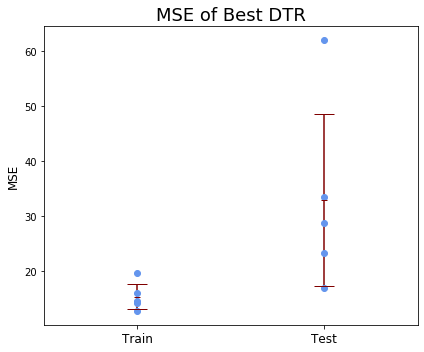

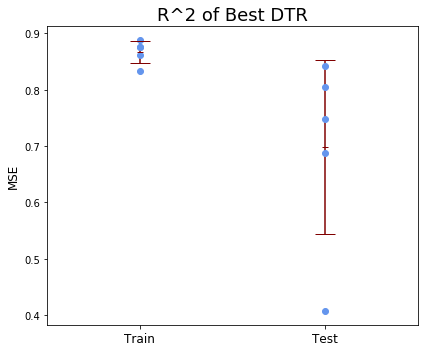

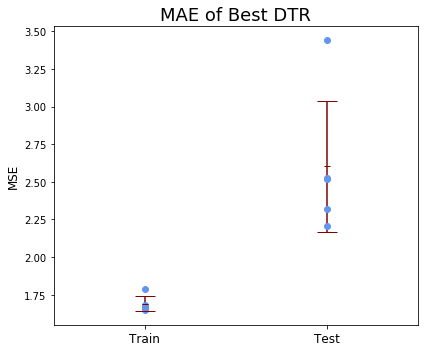

In [299]:
scorenames=['MSE','R^2','MAE']
mean_arr = np.array(dtr_mean).reshape((2,3)) 
std_arr = np.array(dtr_std).reshape((2,3))
dtr_points_arr = dtr_points.reshape((2,3,5))
for i in range(3):
    fig, ax = plt.subplots(figsize=(6,5), tight_layout=True)
    ax.plot([1,1,1,1,1],dtr_points_arr[0][i], linestyle='none',marker="o", color="cornflowerblue",label='train')
    ax.plot([2,2,2,2,2],dtr_points_arr[1][i], linestyle='none',marker="o", color="cornflowerblue",label='test')
    ax.errorbar([1],mean_arr[0][i],std_arr[0][i],
               linestyle='none', marker='_', color='maroon', capsize=10, label='train')
    ax.errorbar([2],mean_arr[1][i],std_arr[1][i],
               linestyle='none', marker='_', color='maroon', capsize=10, label='train')
    ax.set_title("{} of Best DTR".format(scorenames[i]), fontsize=18)
    ax.set_xticklabels(['Train','Test'], fontsize=12)
    ax.set_xticks([1,2])
    ax.set_ylabel("MSE", fontsize=12)
    ax.set_xlim(left=0.5,right=2.5)
    filename="dtr_"+str(scorers[i])+".png"
    plt.savefig(filename)

**The graphs above are indicative of an overfitted model. The metrics for the train set are consistently better than for the test set, and the variance of cross validation scores for the test set is higher than the variance scores for the train set. Another explanation is that the estimator used for cross validation did not inculde a ccp_alpha, which resulted in no pruning in a tree that has split to too great a depth.**

## 3) Random Forest Regression

In [426]:
from sklearn.ensemble import RandomForestRegressor as RFR

t2 = time.time()
ntrees=[100,200,300,500,1000,2500,5000]
regs=[]
train_time=[]
for n in ntrees:
        t0=time.time()
        reg=RFR(n, n_jobs = -1)
        reg.fit(X1_train,y1_train)
        t1=time.time()
        regs.append(reg)
        train_time.append(t1-t0)
        print("Finished fitting for ntrees = {0}. Time elapsed: {1:.3f} s.".format(n,t1-t2))
t3= time.time()
print("Completion time: {0:.3f} s.".format(t3-t2))
print("{0:.3f} minutes.".format((t3-t2)/60))

Finished fitting for ntrees = 100. Time elapsed: 1.212 s.
Finished fitting for ntrees = 200. Time elapsed: 3.265 s.
Finished fitting for ntrees = 300. Time elapsed: 6.673 s.
Finished fitting for ntrees = 500. Time elapsed: 13.576 s.
Finished fitting for ntrees = 1000. Time elapsed: 30.608 s.
Finished fitting for ntrees = 2500. Time elapsed: 72.769 s.
Finished fitting for ntrees = 5000. Time elapsed: 168.421 s.
Completion time: 168.436 s.
2.807 minutes.


In [427]:
#Compute scores for R^2, mse, and median absolute error 
mse_scores=[]
r2_scores=[]
mae_scores=[]
for reg in regs:
    yp=reg.predict(X1_test)
    mse_scores.append(mean_squared_error(y1_test,yp))
    r2_scores.append(r2_score(y1_test,yp))
    mae_scores.append(median_absolute_error(y1_test,yp))

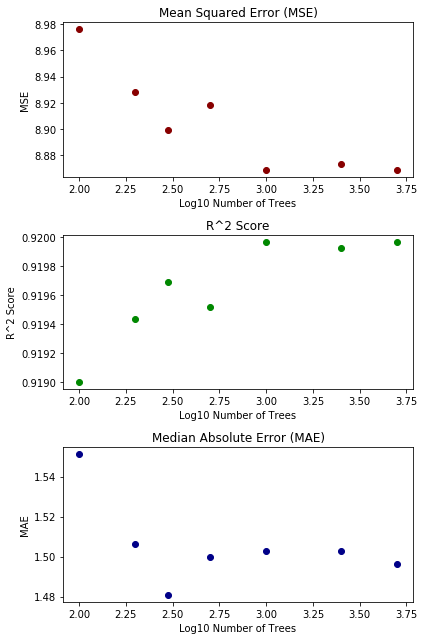

In [429]:
#Plot Scores
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(6,9), tight_layout=True)

ax[0].plot(np.log10(ntrees), mse_scores, linestyle='none',marker="o", color="#880000")
ax[0].set_title("Mean Squared Error (MSE)", fontsize=12)
ax[0].set_xlabel("Log10 Number of Trees")
ax[0].set_ylabel("MSE")

ax[1].plot(np.log10(ntrees), r2_scores, linestyle='none', marker="o",color="#008800")
ax[1].set_title("R^2 Score", fontsize=12)
ax[1].set_xlabel("Log10 Number of Trees")
ax[1].set_ylabel("R^2 Score")

ax[2].plot(np.log10(ntrees), mae_scores, linestyle='none', marker="o", color="#000088")
ax[2].set_title("Median Absolute Error (MAE)", fontsize=12)
ax[2].set_xlabel("Log10 Number of Trees")
ax[2].set_ylabel("MAE")

plt.savefig('randomforesttrials.png')
plt.show()

In [91]:
print("Best Mean Squared Error: {0:.7f}, with n_trees={1}".format(np.min(mse_scores),ntrees[np.where(mse_scores==np.min(mse_scores))[0][0]]))
print("Best R^2 Score: {0:.7f}, with n_trees={1}".format(np.max(r2_scores),ntrees[np.where(r2_scores==np.max(r2_scores))[0][0]]))
print("Best Median Absolute Error: {0:.7f}, with n_trees={1}".format(np.min(mae_scores),ntrees[np.where(mae_scores==np.min(mae_scores))[0][0]]))

Best Mean Squared Error: 8.8275834, with n_trees=500
Best R^2 Score: 0.9203380, with n_trees=500
Best Median Absolute Error: 1.4646700, with n_trees=100


**Finding the optimal ccp_alpha was not feasible for this dataset with my current resources. There were 3408 ccp_alphas computed from cost complexity pruning, and at full processing power it took 126 seconds to fit 10 ccp_alphas. At constant processing power, it would take 11 hours and 54 minutes to fit trees with all possible ccp_alpha values. The code I would use to perform this operation is below.**

In [103]:
#Determine best ccp_alpha for random forest regressor with the optimal number of trees
dt=DecisionTreeRegressor()
reg=RFR(n_estimators=500, max_features=None, oob_score=True)
path = dt.cost_complexity_pruning_path(X1_train,y1_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

count=1 
regs = []
t0=time.time()
for ccp_alpha in ccp_alphas:
    reg = RFR(n_estimators=500, max_features=None, oob_score=True, random_state=42, ccp_alpha=ccp_alpha, n_jobs=-1)
    reg.fit(X1_train, y1_train)
    regs.append(reg)
    t1=time.time()
    if count%10 == 0:
        print("Finished fitting for {0} ccp_alphas out of {1}. Time elapsed: {2:.3f} seconds.".format(count, len(ccp_alphas),t1-t0))
    count +=1
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      regs[-1].tree_.node_count, ccp_alphas[-1]))

#Calculate scores for train set
rf_mse_train_scores=[]
rf_r2_train_scores=[]
rf_mae_train_scores=[]
for reg in regs:
    yp=reg.predict(X1_train)
    mse_scores.append(mean_squared_error(y1_train,yp))
    r2_scores.append(r2_score(y1_train,yp))
    mae_scores.append(median_absolute_error(y1_train,yp))
    
#Calculate scores for test set
rf_mse_test_scores=[]
rf_r2_test_scores=[]
rf_mae_test_scores=[]
for reg in regs:
    yp=reg.predict(X1_test)
    mse_scores.append(mean_squared_error(y1_test,yp))
    r2_scores.append(r2_score(y1_test,yp))
    mae_scores.append(median_absolute_error(y1_test,yp))

Finished fitting for 10 ccp_alphas out of 3408. Time elapsed: 126.875 seconds.
Finished fitting for 20 ccp_alphas out of 3408. Time elapsed: 261.655 seconds.


KeyboardInterrupt: 

### Cross Validation on Best Random Forest Regressor

In [300]:
best_RFR=RFR(n_estimators=500, max_features=None, oob_score=True)

#Create a 2D array containing the 5-fold CV results of the best estimator
#Will iterate over train and test set for MSE, R^2, and MAE
scorers = ["neg_mean_squared_error","r2","neg_median_absolute_error"]
X = [X1_train, X1_test]
y= [y1_train, y1_test]
rfr_points = []
t0=time.time()
for i in range(2):
    for j in range(3):
        points = cross_validate(estimator = best_RFR,
                                  scoring=scorers[j], X = X[i], y = y[i], cv = 5)['test_score']
        rfr_points.append(points)
rfr_points = np.abs(np.array(rfr_points))
t1=time.time()
print("Cross validation complete. Total time elapsed: {0:.3f} seconds.".format(t1-t0))

Cross validation complete. Total time elapsed: 320.916 seconds.


In [302]:
#Create Dataframe for standard deviation and mean for all 3 scoring metrics
rfr_std=[]
t0=time.time()
for i in range(6):
    std = np.std(rfr_points[i])
    rfr_std.append(std)
rfr_std_df = pd.DataFrame(np.array(rfr_std).reshape((2,3)), 
                              columns=['MSE','R^2','MAE'], index=['Train','Test'])

rfr_mean=[]
for i in range(6):
    mean = np.mean(rfr_points[i])
    rfr_mean.append(mean)    
rfr_mean_df = pd.DataFrame(np.array(rfr_mean).reshape((2,3)), 
                              columns=['MSE','R^2','MAE'], index=['Train','Test'])

In [306]:
rfr_mean_df

,MSE,R^2,MAE
Train,9.999495,0.913373,1.629717
Test,19.930006,0.821005,2.682822


In [307]:
rfr_std_df

,MSE,R^2,MAE
Train,0.676921,0.005460,0.079908
Test,2.371650,0.025152,0.186871


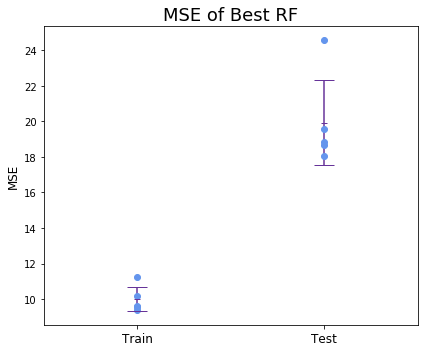

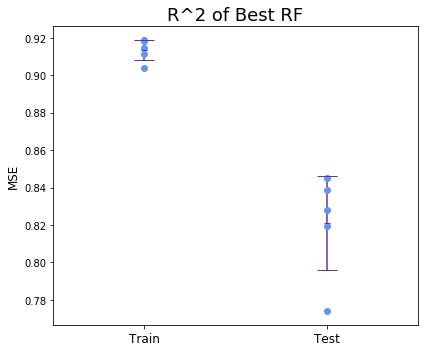

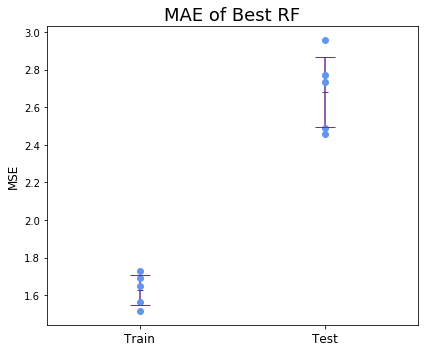

In [305]:
scorenames=['MSE','R^2','MAE']
mean_arr = np.array(rfr_mean).reshape((2,3)) 
std_arr = np.array(rfr_std).reshape((2,3))
rfr_points_arr = rfr_points.reshape((2,3,5))
for i in range(3):
    fig, ax = plt.subplots(figsize=(6,5), tight_layout=True)
    ax.plot([1,1,1,1,1],rfr_points_arr[0][i], linestyle='none',marker="o", color="cornflowerblue",label='train')
    ax.plot([2,2,2,2,2],rfr_points_arr[1][i], linestyle='none',marker="o", color="cornflowerblue",label='test')
    ax.errorbar([1],mean_arr[0][i],std_arr[0][i],
               linestyle='none', marker='_', color='rebeccapurple', capsize=10, label='train')
    ax.errorbar([2],mean_arr[1][i],std_arr[1][i],
               linestyle='none', marker='_', color='rebeccapurple', capsize=10, label='train')
    ax.set_title("{} of Best RF".format(scorenames[i]), fontsize=18)
    ax.set_xticklabels(['Train','Test'], fontsize=12)
    ax.set_xticks([1,2])
    ax.set_ylabel("MSE", fontsize=12)
    ax.set_xlim(left=0.5,right=2.5)
    filename="rfr_"+str(scorers[i])+".png"
    plt.savefig(filename)

**There are also indications of overfitting in the RandomForest data. A possible factor is not being able to calculate the ideal ccp_alpha due to lack of computing resources, resulting in a lack of pruning.**

## 4) Lasso

**Lasso is a linear model that can select the best features and use them in a linear model. For features that do not meet the standard of feature importance dictated by alpha, lasso will set the features equal to zero. Lasso does not require dimensionality reduction, but it does require scaling.**

In [333]:
from sklearn.linear_model import Lasso

#Perform GridSearchCV to find the optimal hyperparameters for SVR
Lasso_hptest1 = {'alpha':[0.01,0.05,0.1,0.5,1]}

#Print number of parameters entered
param_num = []
for key,value in Lasso_hptest1.items():
    param_num.append(len(value))
result = 1
for x in param_num: 
    result = result * x  
print("{} hyperparameters will be tested.".format(result))  

mod=Lasso()
lots_of_Lassos_Cowboy = GridSearchCV(mod, Lasso_hptest1, cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)

5 hyperparameters will be tested.


In [335]:
lots_of_Lassos_Cowboy.fit(X1sc_train,y1sc_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [336]:
print("Parameters of best lasso: {}".format(lots_of_Lassos_Cowboy.best_params_))
print("Mean Squared Error of best lasso: {0:.9f}".format(-1*lots_of_Lassos_Cowboy.best_score_))

Parameters of best lasso: {'alpha': 0.01}
Mean Squared Error of best lasso: 0.837868778


In [337]:
#Perform GridSearchCV to find the optimal hyperparameters for SVR
Lasso_hptest2 = {'alpha':[0.0000001,0.000001,0.00001,0.0001,0.0005,0.001,0.005,0.01,0.05]}

#Print number of parameters entered
param_num = []
for key,value in Lasso_hptest2.items():
    param_num.append(len(value))
result = 1
for x in param_num: 
    result = result * x  
print("{} hyperparameters will be tested.".format(result))  

mod=Lasso()
lots_of_Lassos_Cowboy2 = GridSearchCV(mod, Lasso_hptest2, cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)

9 hyperparameters will be tested.


In [338]:
lots_of_Lassos_Cowboy2.fit(X1sc_train,y1sc_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.0005, 0.001,
                                   0.005, 0.01, 0.05]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [339]:
print("Parameters of best lasso: {}".format(lots_of_Lassos_Cowboy2.best_params_))
print("Mean Squared Error of best lasso: {0:.9f}".format(-1*lots_of_Lassos_Cowboy2.best_score_))

Parameters of best lasso: {'alpha': 0.001}
Mean Squared Error of best lasso: 0.831449784


In [342]:
#Print Number of features used in the best estimator
coeff_used = np.sum(lots_of_Lassos_Cowboy2.best_estimator_.coef_!=0)
print("Number of features used: {}".format(coeff_used))

Number of features used: 17


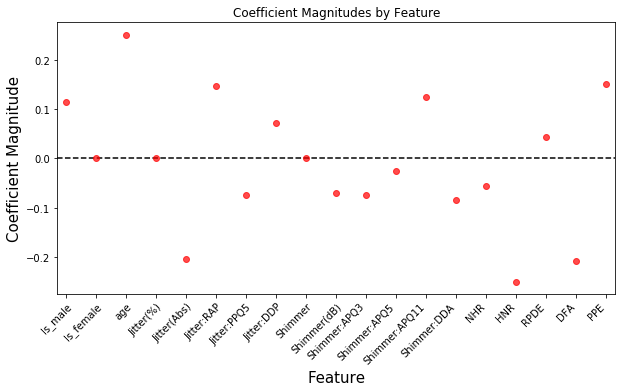

In [433]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(range(0,19),lots_of_Lassos_Cowboy2.best_estimator_.coef_,alpha=0.7,linestyle='none',marker='o',markersize=6,color='red',label=r'Lasso; $\alpha = 1$',zorder=7)
ax.axhline(y=0,c='#000000',ls='--')
ax.set_title("Coefficient Magnitudes by Feature")
ax.set_ylabel('Coefficient Magnitude',fontsize=15)
ax.set_xticklabels(all_features, rotation= 45, ha="right", rotation_mode="anchor")
ax.set_xlabel('Feature', fontsize=15)

ax.set_xticks(range(0,19))
ax.set_xlim(left=-0.3,right=18.3)

plt.savefig('lassostats.png')
plt.show()

### Cross Validation of Best Lasso

In [374]:
#Create a 2D array containing the 5-fold CV results of the best estimator
#Will iterate over train and test set for MSE, R^2, and MAE
scorers = ["neg_mean_squared_error","r2","neg_median_absolute_error"]
X = [X1sc_train, X1sc_test]
y= [y1sc_train, y1sc_test]
lso_points = []
t0=time.time()
for i in range(2):
    for j in range(3):
        points = cross_validate(estimator = lots_of_Lassos_Cowboy2.best_estimator_,
                                  scoring=scorers[j], X = X[i], y = y[i], cv = 5)['test_score']
        lso_points.append(points)
lso_points = np.abs(np.array(lso_points))
t1=time.time()
print("Cross validation complete. Total time elapsed: {0:.3f} seconds.".format(t1-t0))

Cross validation complete. Total time elapsed: 0.436 seconds.


C:\ProgramData\Anaconda3\envs\timebomb\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3484049531538176, tolerance: 0.08841664524149494
  positive)
C:\ProgramData\Anaconda3\envs\timebomb\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3484049531538176, tolerance: 0.08841664524149494
  positive)
C:\ProgramData\Anaconda3\envs\timebomb\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3484049531538176, tolerance: 0.08841664524149494
  positive)


In [375]:
#Create Dataframe for standard deviation and mean for all 3 scoring metrics
lso_std=[]
t0=time.time()
for i in range(6):
    std = np.std(lso_points[i])
    lso_std.append(std)
lso_std_df = pd.DataFrame(np.array(lso_std).reshape((2,3)), 
                              columns=['MSE','R^2','MAE'], index=['Train','Test'])

lso_mean=[]
for i in range(6):
    mean = np.mean(lso_points[i])
    lso_mean.append(mean)    
lso_mean_df = pd.DataFrame(np.array(lso_mean).reshape((2,3)), 
                              columns=['MSE','R^2','MAE'], index=['Train','Test'])

In [376]:
lso_mean_df

,MSE,R^2,MAE
Train,0.831450,0.168531,0.678871
Test,0.836491,0.124798,0.693589


In [377]:
lso_std_df

,MSE,R^2,MAE
Train,0.031854,0.025460,0.022682
Test,0.024294,0.037768,0.055658


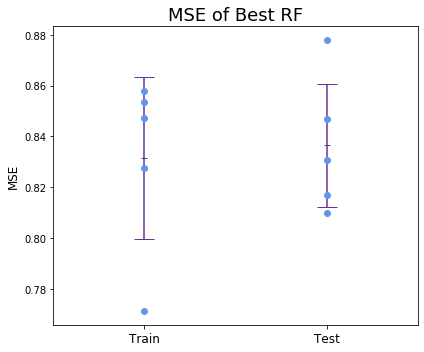

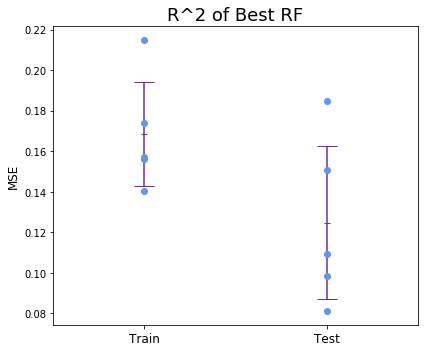

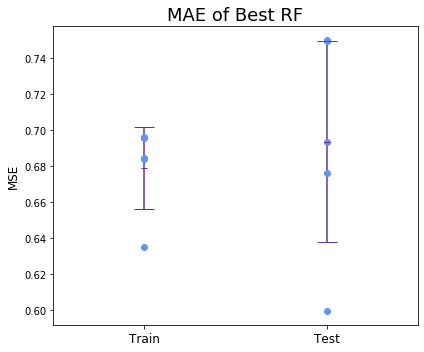

In [378]:
mean_arr = np.array(lso_mean).reshape((2,3)) 
std_arr = np.array(lso_std).reshape((2,3))
lso_points_arr = lso_points.reshape((2,3,5))
for i in range(3):
    fig, ax = plt.subplots(figsize=(6,5), tight_layout=True)
    ax.plot([1,1,1,1,1],lso_points_arr[0][i], linestyle='none',marker="o", color="cornflowerblue",label='train')
    ax.plot([2,2,2,2,2],lso_points_arr[1][i], linestyle='none',marker="o", color="cornflowerblue",label='test')
    ax.errorbar([1],mean_arr[0][i],std_arr[0][i],
               linestyle='none', marker='_', color='rebeccapurple', capsize=10, label='train')
    ax.errorbar([2],mean_arr[1][i],std_arr[1][i],
               linestyle='none', marker='_', color='rebeccapurple', capsize=10, label='train')
    ax.set_title("{} of Best RF".format(scorenames[i]), fontsize=18)
    ax.set_xticklabels(['Train','Test'], fontsize=12)
    ax.set_xticks([1,2])
    ax.set_ylabel("MSE", fontsize=12)
    ax.set_xlim(left=0.5,right=2.5)
    filename="lso_"+str(scorers[i])+".png"
    plt.savefig(filename)

# Side by Side Analysis of Models

In [401]:
#df of mse for all models
all_mean_mse_df = pd.DataFrame(np.array([pca_svr_mean_df['MSE'].values, 
                                         dtr_mean_df['MSE'].values, 
                                         rfr_mean_df['MSE'].values, 
                                         lso_mean_df['MSE'].values]), 
                               index=['PCA-SVR','DTR','RF','Lasso'], columns=['Train MSE','Test MSE'])
all_mean_mse_df = all_mean_mse_df.transpose()
all_mean_mse_df

,PCA-SVR,DTR,RF,Lasso
Train MSE,0.713734,15.363434,9.999495,0.831450
Test MSE,0.680129,32.881746,19.930006,0.836491


In [402]:
#r^2 for all models
all_mean_r2_df = pd.DataFrame(np.array([pca_svr_mean_df['R^2'].values, 
                                         dtr_mean_df['R^2'].values, 
                                         rfr_mean_df['R^2'].values, 
                                         lso_mean_df['R^2'].values]), 
                               index=['PCA-SVR','DTR','RF','Lasso'], columns=['Train R^2','Test R^2'])
all_mean_r2_df = all_mean_r2_df.transpose()
all_mean_r2_df

,PCA-SVR,DTR,RF,Lasso
Train R^2,0.286405,0.866963,0.913373,0.168531
Test R^2,0.290475,0.698136,0.821005,0.124798


In [403]:
#MAE for all models
all_mean_mae_df = pd.DataFrame(np.array([pca_svr_mean_df['MAE'].values, 
                                         dtr_mean_df['MAE'].values, 
                                         rfr_mean_df['MAE'].values, 
                                         lso_mean_df['MAE'].values]), 
                               index=['PCA-SVR','DTR','RF','Lasso'], columns=['Train MAE','Test MAE'])
all_mean_mae_df = all_mean_mae_df.transpose()
all_mean_mae_df

,PCA-SVR,DTR,RF,Lasso
Train MAE,0.517133,1.690229,1.629717,0.678871
Test MAE,0.510269,2.603326,2.682822,0.693589


In [407]:
#Standard deviation of mean squared error values across models
all_std_mse_df = pd.DataFrame(np.array([pca_svr_std_df['MSE'].values, 
                                         dtr_std_df['MSE'].values, 
                                         rfr_std_df['MSE'].values, 
                                         lso_std_df['MSE'].values]), 
                               index=['PCA-SVR','DTR','RF','Lasso'], columns=['Train MSE stdev','Test MSE stdev'])
all_std_mse_df = all_std_mse_df.transpose()
all_std_mse_df

,PCA-SVR,DTR,RF,Lasso
Train MSE stdev,0.032976,2.346519,0.676921,0.031854
Test MSE stdev,0.070487,15.591133,2.371650,0.024294


In [406]:
#Standard deviation of r^2 values across models
all_std_r2_df = pd.DataFrame(np.array([pca_svr_std_df['R^2'].values, 
                                         dtr_std_df['R^2'].values, 
                                         rfr_std_df['R^2'].values, 
                                         lso_std_df['R^2'].values]), 
                               index=['PCA-SVR','DTR','RF','Lasso'], columns=['Train R^2 stdev','Test R^2 stdev'])
all_std_r2_df = all_std_r2_df.transpose()
all_std_r2_df

,PCA-SVR,DTR,RF,Lasso
Train R^2 stdev,0.023938,0.019150,0.005460,0.025460
Test R^2 stdev,0.052326,0.154655,0.025152,0.037768


In [408]:
#Standard deviation of MAE values across models
all_std_mae_df = pd.DataFrame(np.array([pca_svr_std_df['MAE'].values, 
                                         dtr_std_df['MAE'].values, 
                                         rfr_std_df['MAE'].values, 
                                         lso_std_df['MAE'].values]), 
                               index=['PCA-SVR','DTR','RF','Lasso'], columns=['Train MAE stdev','Test MAE stdev'])
all_std_mae_df = all_std_mae_df.transpose()
all_std_mae_df

,PCA-SVR,DTR,RF,Lasso
Train MAE stdev,0.019317,0.049907,0.079908,0.022682
Test MAE stdev,0.015536,0.436453,0.186871,0.055658


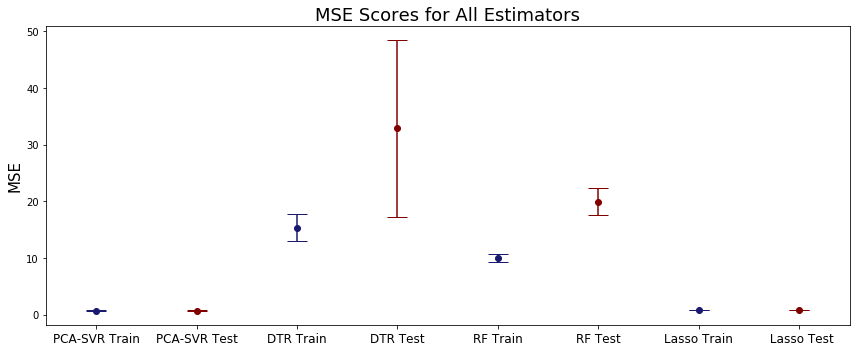

In [421]:
fig, ax = plt.subplots(figsize=(12,5), tight_layout=True)

#PCA-SVR
ax.plot([1],all_mean_mse_df.values[0][0], linestyle='none',marker="o", color="midnightblue",label='train')
ax.plot([2],all_mean_mse_df.values[1][0], linestyle='none',marker="o", color="maroon",label='test')
ax.errorbar([1],all_mean_mse_df.values[0][0], all_std_mse_df.values[0][0],
               linestyle='none', marker='_', color='midnightblue', capsize=10, label='train')
ax.errorbar([2],all_mean_mse_df.values[1][0], all_std_mse_df.values[1][0],
               linestyle='none', marker='_', color="maroon", capsize=10, label='test')

#DTR
ax.plot([3],all_mean_mse_df.values[0][1], linestyle='none',marker="o", color="midnightblue",label='train')
ax.plot([4],all_mean_mse_df.values[1][1], linestyle='none',marker="o", color="maroon",label='test')
ax.errorbar([3],all_mean_mse_df.values[0][1], all_std_mse_df.values[0][1],
               linestyle='none', marker='_', color='midnightblue', capsize=10, label='train')
ax.errorbar([4],all_mean_mse_df.values[1][1], all_std_mse_df.values[1][1],
               linestyle='none', marker='_', color="maroon", capsize=10, label='test')

#RF
ax.plot([5],all_mean_mse_df.values[0][2], linestyle='none',marker="o", color="midnightblue",label='train')
ax.plot([6],all_mean_mse_df.values[1][2], linestyle='none',marker="o", color="maroon",label='test')
ax.errorbar([5],all_mean_mse_df.values[0][2], all_std_mse_df.values[0][2],
               linestyle='none', marker='_', color='midnightblue', capsize=10, label='train')
ax.errorbar([6],all_mean_mse_df.values[1][2], all_std_mse_df.values[1][2],
               linestyle='none', marker='_', color="maroon", capsize=10, label='test')

#Lasso
ax.plot([7],all_mean_mse_df.values[0][3], linestyle='none',marker="o", color="midnightblue",label='train')
ax.plot([8],all_mean_mse_df.values[1][3], linestyle='none',marker="o", color="maroon",label='test')
ax.errorbar([7],all_mean_mse_df.values[0][3], all_std_mse_df.values[0][3],
               linestyle='none', marker='_', color='midnightblue', capsize=10, label='train')
ax.errorbar([8],all_mean_mse_df.values[1][3], all_std_mse_df.values[1][3],
               linestyle='none', marker='_', color="maroon", capsize=10, label='test')

ax.set_title("MSE Scores for All Estimators", fontsize=18)
ax.set_xticklabels(['PCA-SVR Train','PCA-SVR Test','DTR Train','DTR Test','RF Train','RF Test','Lasso Train',' Lasso Test'], fontsize=12)
ax.set_xticks([1,2,3,4,5,6,7,8])

ax.set_ylabel("MSE", fontsize=15)
ax.set_xlim(left=0.5,right=8.5)

filename="all_MSE.png"
plt.savefig(filename)

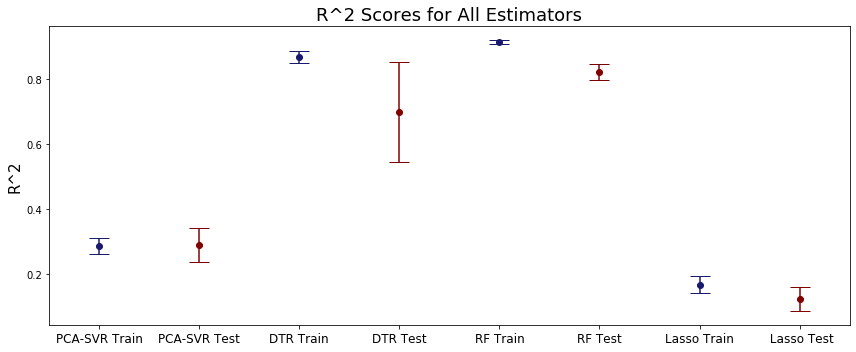

In [422]:
fig, ax = plt.subplots(figsize=(12,5), tight_layout=True)

#PCA-SVR
ax.plot([1],all_mean_r2_df.values[0][0], linestyle='none',marker="o", color="midnightblue",label='train')
ax.plot([2],all_mean_r2_df.values[1][0], linestyle='none',marker="o", color="maroon",label='test')
ax.errorbar([1],all_mean_r2_df.values[0][0], all_std_r2_df.values[0][0],
               linestyle='none', marker='_', color='midnightblue', capsize=10, label='train')
ax.errorbar([2],all_mean_r2_df.values[1][0], all_std_r2_df.values[1][0],
               linestyle='none', marker='_', color="maroon", capsize=10, label='test')

#DTR
ax.plot([3],all_mean_r2_df.values[0][1], linestyle='none',marker="o", color="midnightblue",label='train')
ax.plot([4],all_mean_r2_df.values[1][1], linestyle='none',marker="o", color="maroon",label='test')
ax.errorbar([3],all_mean_r2_df.values[0][1], all_std_r2_df.values[0][1],
               linestyle='none', marker='_', color='midnightblue', capsize=10, label='train')
ax.errorbar([4],all_mean_r2_df.values[1][1], all_std_r2_df.values[1][1],
               linestyle='none', marker='_', color="maroon", capsize=10, label='test')

#RF
ax.plot([5],all_mean_r2_df.values[0][2], linestyle='none',marker="o", color="midnightblue",label='train')
ax.plot([6],all_mean_r2_df.values[1][2], linestyle='none',marker="o", color="maroon",label='test')
ax.errorbar([5],all_mean_r2_df.values[0][2], all_std_r2_df.values[0][2],
               linestyle='none', marker='_', color='midnightblue', capsize=10, label='train')
ax.errorbar([6],all_mean_r2_df.values[1][2], all_std_r2_df.values[1][2],
               linestyle='none', marker='_', color="maroon", capsize=10, label='test')

#Lasso
ax.plot([7],all_mean_r2_df.values[0][3], linestyle='none',marker="o", color="midnightblue",label='train')
ax.plot([8],all_mean_r2_df.values[1][3], linestyle='none',marker="o", color="maroon",label='test')
ax.errorbar([7],all_mean_r2_df.values[0][3], all_std_r2_df.values[0][3],
               linestyle='none', marker='_', color='midnightblue', capsize=10, label='train')
ax.errorbar([8],all_mean_r2_df.values[1][3], all_std_r2_df.values[1][3],
               linestyle='none', marker='_', color="maroon", capsize=10, label='test')

ax.set_title("R^2 Scores for All Estimators", fontsize=18)
ax.set_xticklabels(['PCA-SVR Train','PCA-SVR Test','DTR Train','DTR Test','RF Train','RF Test','Lasso Train',' Lasso Test'], fontsize=12)
ax.set_xticks([1,2,3,4,5,6,7,8])

ax.set_ylabel("R^2", fontsize=15)
ax.set_xlim(left=0.5,right=8.5)

filename="all_R2.png"
plt.savefig(filename)

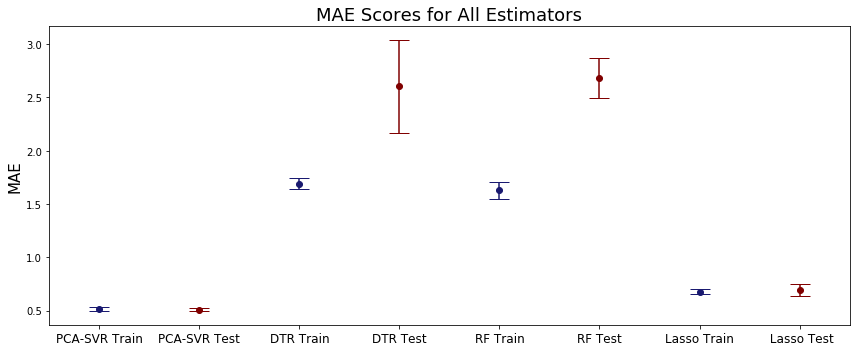

In [423]:
fig, ax = plt.subplots(figsize=(12,5), tight_layout=True)

#PCA-SVR
ax.plot([1],all_mean_mae_df.values[0][0], linestyle='none',marker="o", color="midnightblue",label='train')
ax.plot([2],all_mean_mae_df.values[1][0], linestyle='none',marker="o", color="maroon",label='test')
ax.errorbar([1],all_mean_mae_df.values[0][0], all_std_mae_df.values[0][0],
               linestyle='none', marker='_', color='midnightblue', capsize=10, label='train')
ax.errorbar([2],all_mean_mae_df.values[1][0], all_std_mae_df.values[1][0],
               linestyle='none', marker='_', color="maroon", capsize=10, label='test')

#DTR
ax.plot([3],all_mean_mae_df.values[0][1], linestyle='none',marker="o", color="midnightblue",label='train')
ax.plot([4],all_mean_mae_df.values[1][1], linestyle='none',marker="o", color="maroon",label='test')
ax.errorbar([3],all_mean_mae_df.values[0][1], all_std_mae_df.values[0][1],
               linestyle='none', marker='_', color='midnightblue', capsize=10, label='train')
ax.errorbar([4],all_mean_mae_df.values[1][1], all_std_mae_df.values[1][1],
               linestyle='none', marker='_', color="maroon", capsize=10, label='test')

#RF
ax.plot([5],all_mean_mae_df.values[0][2], linestyle='none',marker="o", color="midnightblue",label='train')
ax.plot([6],all_mean_mae_df.values[1][2], linestyle='none',marker="o", color="maroon",label='test')
ax.errorbar([5],all_mean_mae_df.values[0][2], all_std_mae_df.values[0][2],
               linestyle='none', marker='_', color='midnightblue', capsize=10, label='train')
ax.errorbar([6],all_mean_mae_df.values[1][2], all_std_mae_df.values[1][2],
               linestyle='none', marker='_', color="maroon", capsize=10, label='test')

#Lasso
ax.plot([7],all_mean_mae_df.values[0][3], linestyle='none',marker="o", color="midnightblue",label='train')
ax.plot([8],all_mean_mae_df.values[1][3], linestyle='none',marker="o", color="maroon",label='test')
ax.errorbar([7],all_mean_mae_df.values[0][3], all_std_mae_df.values[0][3],
               linestyle='none', marker='_', color='midnightblue', capsize=10, label='train')
ax.errorbar([8],all_mean_mae_df.values[1][3], all_std_mae_df.values[1][3],
               linestyle='none', marker='_', color="maroon", capsize=10, label='test')

ax.set_title("MAE Scores for All Estimators", fontsize=18)
ax.set_xticklabels(['PCA-SVR Train','PCA-SVR Test','DTR Train','DTR Test','RF Train','RF Test','Lasso Train',' Lasso Test'], fontsize=12)
ax.set_xticks([1,2,3,4,5,6,7,8])

ax.set_ylabel("MAE", fontsize=15)
ax.set_xlim(left=0.5,right=8.5)

filename="all_mae.png"
plt.savefig(filename)

# Conclusion and Discussion

**The best model to use for prediction of total_UPDRS score was determined, though further refinement of models is necessary to optimize the prediction to results. Based on mean squared error and median absolute error, PCA-SVR was the best model to use, with an average test mean squared error of 0.680 accross 5 cross-validations. The average median absolute error for the test set is 0.510. However, due to the use of feature scaling only for PCA-SVR and Lasso, these metrics are likely inaccurate since they depend on the scale of the label. R^2 does not depend on scaling, so it is the best metric to use.**

**Based on the use of R^2, the best model is random forest regression with 500 trees, with an average test r^2 value of 0.82. With a dataset that has high correlations between features and features with very low correlations with the model, this is expected because random forest is not sensitive to colinearity of features, and is able to classify features based on the mean values of samples at each node.**

**Many of the models performed poorly, and much can be done in the future to improve results. With randomforest and decision tree regression, overfitting was observed for the best estimator. To reduce this, it would be helpful to repeat cost complexity pruning with proper technique. Processing speed was a barrier to performing cost complexity pruning, therefore repeating this step with more powerful computer should yield better results. Both PCA and lasso showed test R^2 values of less than 0.2, indicating that they were unable to fit a model that forms a strong correlation between the features and the UPDRS score. This could have been due to errors encountered with scaling, and in future analyses this should be revisited to ensure that proper procedures have been followed.**

**Further analyses could include applying CNN to visualization of the sound waves generated in the data. It is possible that the wave amplitude patterns could be distinct for people with early stage Parkinson's, and that using CNN to learn the shape of each sound wave could allow the computer to identify distinct soundwaves in those with the disorder.**

### References

Little MA, McSharry PE, Hunter EJ, Ramig LO (2009),
'Suitability of dysphonia measurements for telemonitoring of Parkinson's 
disease',
IEEE Transactions on Biomedical Engineering, 56(4):1015-1022

Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM.
'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice 
Disorder Detection',
BioMedical Engineering OnLine 2007, 6:23 (26 June 2007) 